In [1]:
from __future__ import division
import cPickle as pkl
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Load matched samples

In [ ]:
matched_df = pd.read_csv('../tmp/matched_CEM_table.csv', header=0, index_col=0)
print(matched_df.head())
print(matched_df.shape)

# Load raw data

In [ ]:
def load_data(dump_files):
    """Extract sequences, extra info and patient id from dump pkl."""
    # Positive raw data load
    raw_data = []
    extra_info = []
    indexes = []
    for f in tqdm(dump_files, desc='Loading dump files'):
        _tmp = pkl.load(open(os.path.join('..', 'tmp', f), 'rb'))
        _raw_data, _extra_info = _tmp['raw_data'], _tmp['extra_info']
        for k in _extra_info.index:
            if len(_raw_data[k])>0: # Skip empty sequences
                raw_data.append(_raw_data[k])
                extra_info.append([_extra_info.loc[k]['SEX'], _extra_info.loc[k]['AGE']])
                indexes.append(k)
    return raw_data, extra_info, indexes

In [ ]:
dump_files = filter(lambda x: 'raw_data' in x, os.listdir('../tmp/'))
positive_dump_files = filter(lambda x: 'class_1' in x, dump_files)
negative_dump_files = filter(lambda x: 'class_0' in x, dump_files)

Sequences should be like `['A', 8, 'M', 0, ...]` where letters are btos and numbers are weeks from one btos to another

In [ ]:
pos_raw_data, pos_extra_info, pos_id = load_data(positive_dump_files)
print(len(pos_id), 'positive samples')

In [ ]:
neg_raw_data, neg_extra_info, neg_id = load_data(negative_dump_files)
print(len(neg_id), 'negative samples')

# Keep only the matched samples

In [ ]:
df1 = pd.DataFrame(data=pos_raw_data, index=pos_id, columns=['Seq'])
df1 = pd.merge(matched_df[matched_df['CLASS'] == 1], df1, left_index=True, right_index=True, how='left')[['Seq']]
df1['Class'] = 1
print(df1.shape)
print(df1.head())

In [ ]:
df0 = pd.DataFrame(data=neg_raw_data, index=neg_id, columns=['Seq'])
df0 = pd.merge(matched_df[matched_df['CLASS'] == 0], df0, left_index=True, right_index=True, how='left')[['Seq']]
df0['Class'] = 0
print(df0.shape)
print(df0.head())

In [ ]:
df = pd.concat((df1, df0))
print(df.head())
print(df.tail())
print(df.shape)

In [ ]:
df.to_csv('../tmp/matched_sequences.csv')

# Make Xy

In [ ]:
# Tfidf representation
from sklearn.feature_extraction.text import TfidfVectorizer

max_ngram = 6
max_features = 1000

print('Creating Tfidf')
tfidf = TfidfVectorizer(analyzer='char', ngram_range=[1, max_ngram], max_features=1000)
X = tfidf.fit_transform(df['Seq']).todense()

# Feature names
feat_names = tfidf.vocabulary_.keys()

# Tfidf - DataFrame
dfx = pd.DataFrame(data=X, index=df.index, columns=feat_names)
dfy = pd.DataFrame(data=df['Class'], index=df.index, columns=['Class'])

print('Save dataset')
dfx.to_csv('Tfidf_{}-gram_data.csv'.format(max_ngram))
dfy.to_csv('Tfidf_{}-gram_labels.csv'.format(max_ngram))
print('done.')

In [ ]:
# Bag-of-words representation
from sklearn.feature_extraction.text import CountVectorizer

# Create 3 data sets
for max_ngram in [1, 2, 3]:
    print('max ngram: ', max_ngram)
    bow = CountVectorizer(analyzer='char', ngram_range=[1, max_ngram])
    
    print('Creating BOW...')
    X = bow.fit_transform(df['Seq']).todense()
    
    # Feature names
    feat_names = bow.vocabulary_.keys()
    
    # BOW - DataFrame
    dfx = pd.DataFrame(data=X, index=df.index, columns=feat_names)
    dfy = pd.DataFrame(data=df['Class'], index=df.index, columns=['Class'])
    
    print('Save dataset')
    dfx.to_csv('BOW_{}-gram_data.csv'.format(max_ngram))
    dfy.to_csv('BOW_{}-gram_labels.csv'.format(max_ngram))
    print('done.')

# Load the desired BOW dataset

In [3]:
ngram=1

_dfx = pd.read_csv('BOW-datasets/BOW_{}-gram_data.csv'.format(ngram), header=0, index_col=0)
_dfy = pd.read_csv('BOW-datasets/BOW_{}-gram_labels.csv'.format(ngram), header=0, index_col=0)
# _dfx = pd.read_csv('BOW-datasets/Tfidf_{}-gram_data.csv'.format(ngram), header=0, index_col=0)
# _dfy = pd.read_csv('BOW-datasets/Tfidf_{}-gram_labels.csv'.format(ngram), header=0, index_col=0)

X = _dfx.values
y = _dfy.values
feat_names = _dfx.columns
print(X.shape)

(57612, 17)


# Learning

In [4]:
# Simple assessment
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import (accuracy_score, roc_auc_score,
                             precision_score, recall_score,
                             f1_score, matthews_corrcoef,
                             make_scorer)

def roc_auc_scorer(estimator, X, y):
    return roc_auc_score(y, estimator.predict_proba(X)[:,1])

_metrics = {'Accuracy': make_scorer(accuracy_score),
            'ROC_AUC': roc_auc_scorer,
            'Precision': make_scorer(precision_score),
            'Recall': make_scorer(recall_score),
            'F1': make_scorer(f1_score),
            'MCC': make_scorer(matthews_corrcoef)}

pipe = Pipeline([('pp', StandardScaler()),
                 ('mdl', LogisticRegression(penalty='l1'))])

scores = cross_validate(pipe, X, y, cv=5, n_jobs=-1, scoring=_metrics)
scores = pd.DataFrame(scores).transpose()
scores[r'avg $\pm$ std'] = [r'{:1.3f} $\pm$ {:1.3f}'.format(m, s) for m,s in zip(np.mean(scores.values, axis=1), np.std(scores.values, axis=1))]
scores

,0,1,2,3,4,avg $\pm$ std
fit_time,0.362998,0.379166,0.307819,0.340381,0.409378,0.360 $\pm$ 0.034
score_time,0.071834,0.085176,0.066567,0.107213,0.073380,0.081 $\pm$ 0.015
test_Accuracy,0.960083,0.964503,0.947926,0.874414,0.703524,0.890 $\pm$ 0.099
test_F1,0.961089,0.965720,0.948840,0.865358,0.603160,0.869 $\pm$ 0.138
test_MCC,0.921400,0.931355,0.896425,0.755697,0.471861,0.795 $\pm$ 0.174
test_Precision,0.937459,0.933712,0.932462,0.932611,0.911837,0.930 $\pm$ 0.009
test_ROC_AUC,0.986502,0.997434,0.991185,0.962598,0.800717,0.948 $\pm$ 0.074
test_Recall,0.985942,1.000000,0.965805,0.807152,0.450616,0.842 $\pm$ 0.208
train_Accuracy,0.881466,0.880473,0.884530,0.901280,0.939944,0.898 $\pm$ 0.022
train_F1,0.874394,0.874719,0.879161,0.896905,0.939133,0.893 $\pm$ 0.025


# Dataviz

In [7]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import Normalizer

sss = StratifiedShuffleSplit(n_splits=1, test_size=500)
_, _idx = next(sss.split(X, y))

In [8]:
pipe = Pipeline([('pp', Normalizer()),
                 ('dr', TSNE(n_components=3, init='pca'))])

x_r = pipe.fit_transform(X)

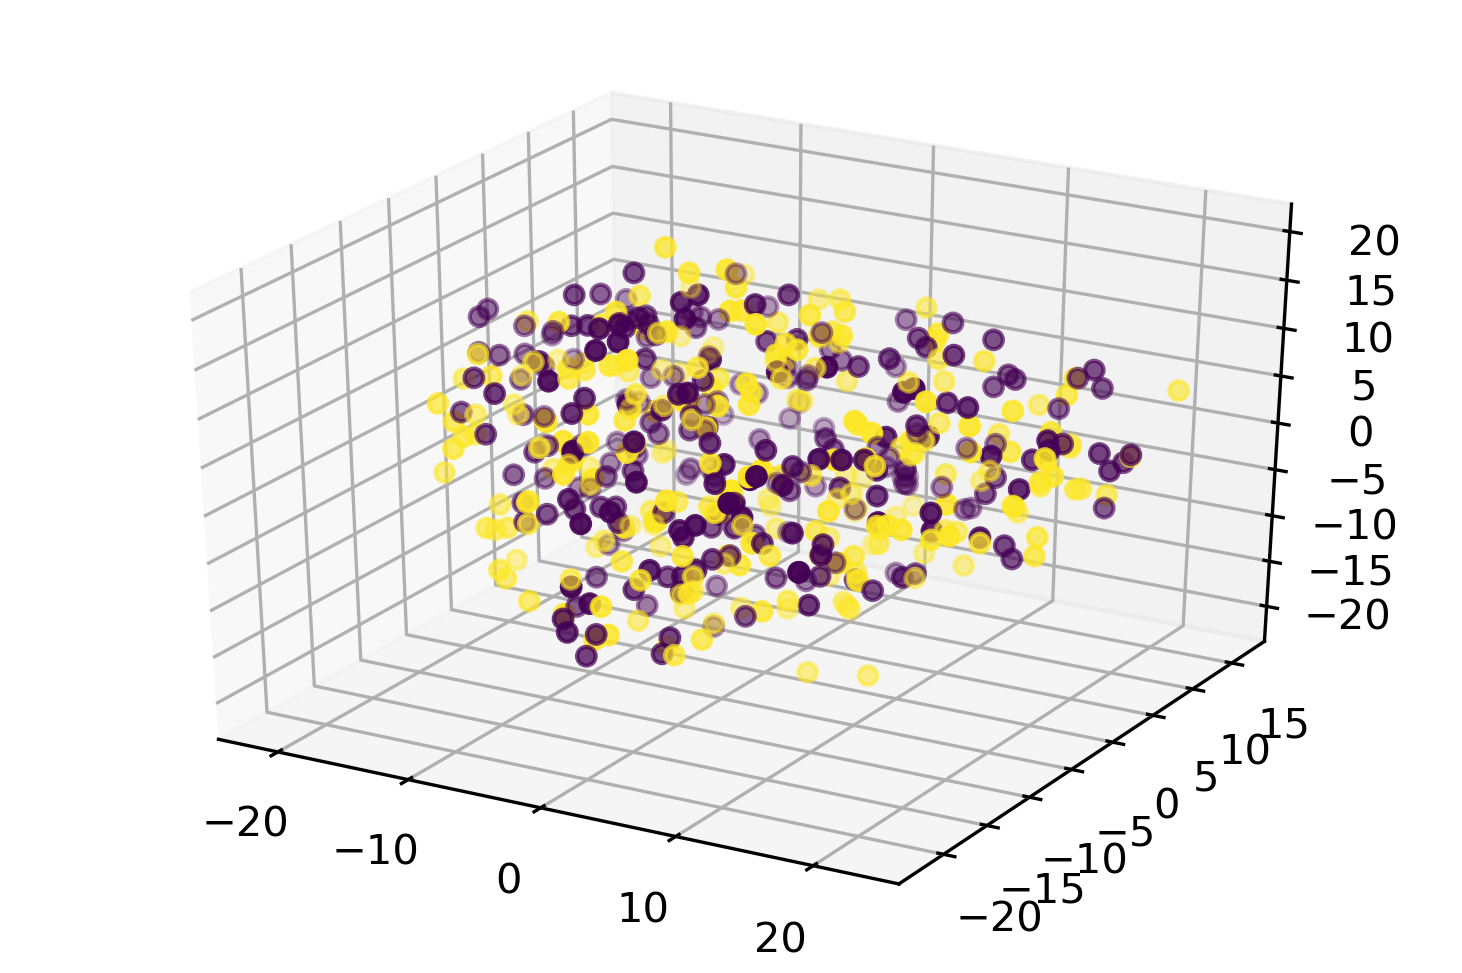

In [9]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111, projection='3d')

xs = x_r[_idx, 0]
ys = x_r[_idx, 1]
zs = x_r[_idx, 2]
ax.scatter(xs, ys, zs, c=y[_idx].ravel());